# Imports

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs


In [ ]:
pip install tensorflow-addons


In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from tensorflow.keras import layers
from imutils import paths
from tqdm import tqdm

import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128


In [ ]:
#trainfilepath = ("/content/gdrive/MyDrive/DissertationVideosSorted/train.csv")
#testfilepath = ("/content/gdrive/MyDrive/DissertationVideosSorted/test.csv")

In [ ]:
trainfilepath = ("./VideosSorted/train.csv")
testfilepath = ("./VideosSorted/test.csv")

In [ ]:
train_df = pd.read_csv(trainfilepath)
test_df = pd.read_csv(testfilepath)

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 735
Total videos for testing: 326


# Feature Extraction

In [ ]:
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped


# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
    #feature_extractor = keras.applications.EfficientNetB0(
    #feature_extractor = keras.applications.MobileNet(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    #preprocess_input = keras.applications.mobilenet.preprocess_input
    preprocess_input = keras.applications.densenet.preprocess_input
    #preprocess_input = keras.applications.efficientnet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in tqdm(enumerate(video_paths)):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

['breaststroke', 'diving', 'drowning', 'frontcrawl', 'jetski', 'kayaking', 'notdrowning', 'rafting', 'rowing', 'surfing']


In [ ]:
#trainrootdir = ("/content/gdrive/MyDrive/DissertationVideosSorted/train")
#testrootdir = ("/content/gdrive/MyDrive/DissertationVideosSorted/test")

In [ ]:
trainrootdir = ("./VideosSorted/train")
testrootdir = ("./VideosSorted/test")

In [ ]:
train_data, train_labels = prepare_all_videos(train_df, trainrootdir)
test_data, test_labels = prepare_all_videos(test_df, testrootdir)

print(f"Frame features in train set: {train_data.shape}")

735it [40:26,  3.30s/it]
326it [17:01,  3.13s/it]

Frame features in train set: (735, 20, 1024)


# Defining Transformer

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report

In [ ]:
from tensorflow_addons import metrics
from tensorflow_addons import losses
from sklearn.metrics import confusion_matrix


In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=0)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

lr=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=1000,  decay_rate=0.9, staircase=1)

# Compiling final model and evaluations

Epoch 1/50
22/23 [===========================>..] - ETA: 0s - loss: 4.2509 - accuracy: 0.3097
Epoch 1: val_loss improved from inf to 1.69514, saving model to /tmp/video_classifier
23/23 [==============================] - 3s 47ms/step - loss: 4.1918 - accuracy: 0.3143 - val_loss: 1.6951 - val_accuracy: 0.5307
Epoch 2/50
22/23 [===========================>..] - ETA: 0s - loss: 2.0404 - accuracy: 0.5142
Epoch 2: val_loss improved from 1.69514 to 0.97268, saving model to /tmp/video_classifier
23/23 [==============================] - 1s 29ms/step - loss: 2.0544 - accuracy: 0.5129 - val_loss: 0.9727 - val_accuracy: 0.7117
Epoch 3/50
22/23 [===========================>..] - ETA: 0s - loss: 1.4683 - accuracy: 0.5923
Epoch 3: val_loss improved from 0.97268 to 0.70884, saving model to /tmp/video_classifier
23/23 [==============================] - 1s 29ms/step - loss: 1.4398 - accuracy: 0.6014 - val_loss: 0.7088 - val_accuracy: 0.7761
Epoch 4/50
22/23 [===========================>..] - ETA: 0s - 

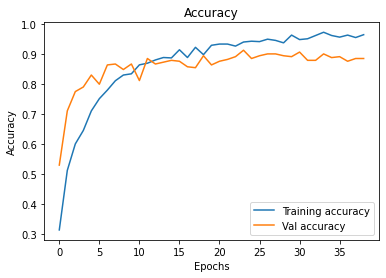

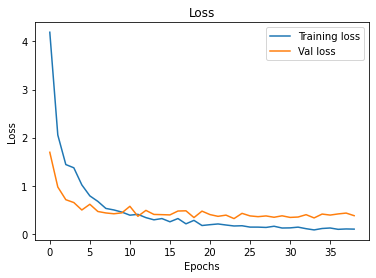

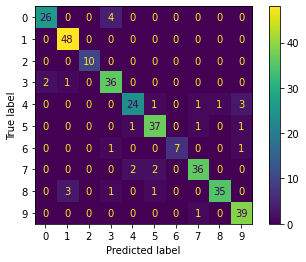

In [ ]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 3
    num_heads = 3
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
   
    
    x = layers.GlobalMaxPooling1D()(x)


    x = layers.Dropout(0.7)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer= "SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1,
    )
    
    

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_data=(test_data, test_labels),
        epochs=50,
        callbacks=[checkpoint, earlystop]
    )


    #Plot Graphs
    plt.figure(0)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Val accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(1)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

   






    #Experiments Summary
    model.load_weights(filepath)
    model_results = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(model_results[1] * 100, 2)}%")
    print("Test loss:" + str(model_results[0]))
    


    test_pred = model.predict(test_data)
    test_pred = list(np.argmax(test_pred,axis = 1))

   
    #Cohen's Kappa and F1 Score
    labels = label_processor.get_vocabulary()
    ConfusionMatrixDisplay.from_predictions(test_labels, test_pred)

    print("Cohen's Kappa:"+str (cohen_kappa_score(test_labels, test_pred)))
    print(classification_report(test_labels, test_pred))
    



    return model
trained_model = run_experiment()